# EECS 491 - A2 - E1
### Tristan Maidment - tdm47

## Goal
The goal for this exercise is to use the TCP data acquired from the wireshark dump made in A1.  By using the same model, we can create a simple example with real data that can be solved via sampling and variable elimination.

## Implementation

In [1]:
import pymc3 as pm
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from pymc3.math import switch
from pymc3 import Bernoulli
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The data from A1 is imported, and a new parameter, `hops_retrans_all`, is used to determine all retransmission events, including ones that are not Fast Retransmits and Timeouts.

In [2]:
hops = []
hops_retrans = []
hops_timeout = []
hops_retrans_all = []
with open('TTL3.csv', newline='') as csvfile:
    ttls = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in ttls:
        if row[1]:
            ttl = 64 - int(row[1])
            #I removed all TTL that are below 0.  
            #These TTL are either set at a value higher than 64 by the sender,
            #or packets being sent to local devices on my home network. (TTL = 0)
            if ttl > 0:
                if "[TCP Retransmission]" in row[2]:
                    hops_timeout.append(ttl)
                elif "[TCP Fast Retransmission]" in row[2]:
                    hops_retrans.append(ttl)
                elif "retransmission" in row[2]:
                    hops_retrans_all.append(ttl)
                else:
                    hops.append(ttl)
pkt_total = len(hops) + len(hops_timeout) + len(hops_retrans) + len(hops_retrans_all)
pkt_succ = len(hops)
pkt_time = len(hops_timeout)
pkt_fast = len(hops_retrans)
print("Packets successful", pkt_succ)
print("Packets unsuccessful", pkt_total - pkt_succ)
print("Packets timed_out", pkt_time)
print("Packets fast_retransmitted", pkt_fast)
print("Percent unsuccessful", (pkt_total - pkt_succ)/pkt_total)
print("Percent timed_out", pkt_time/pkt_total)
print("Percent fast_retransmitted", pkt_fast/pkt_total)
print("Packets total", pkt_total)

Packets successful 104458
Packets unsuccessful 204
Packets timed_out 73
Packets fast_retransmitted 43
Percent unsuccessful 0.0019491314899390418
Percent timed_out 0.0006974833272821081
Percent fast_retransmitted 0.0004108463434675431
Packets total 104662


$$
\begin{align}
P(R) & = 0.0019491314899390418 \\
P(T | R) & = 0.357843137254902 \\ 
P(F | R) & = 0.21078431372549 \\
P(T | \bar R) & = 0.0111083296707496513 \\ 
P(F | \bar R) & = 0.0236974833272821081 \\
P(T) &= 0.0006974833272821081 \\
P(F) &= 0.0004108463434675431 \\
\end{align}
$$

Due to inaccuracies present in Wireshark, and the present of other modern TCP optimizations, we will assume that Wiresharks representation of P(T) and P(F) are independent.  For the purpose of this exercise, we will assume that we estimated the following:

$$
\begin{align}
P(T = true| R = false, F = false) & = 0.3212359034102345301 \\
P(T = true| R = false, F = true) & = 0.0111083296707496513 \\
P(T = true| R = true, F = false) & = 0.1767348075841529761 \\
P(T = true| R = true, F = true) & = 0.0236974833272821081 \\
\end{align}
$$

Using this data we can define the model.

In [32]:
with pm.Model() as model:
    retransmit = Bernoulli('Retransmit', 0.0019491314899390418)
    fast_retransmit = Bernoulli('Fast Retransmit', switch(retransmit, 0.21078431372549, 0.0236974833272821081))
    timeout = Bernoulli('Timeout', switch(retransmit, 0.357843137254902, 0.0111083296707496513))

Using that model, we can sample the network.  Due to the very low probabilities, a large sampling value must be used for accurate results.

Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [Retransmit, Fast Retransmit, Timeout]
100%|██████████| 40500/40500 [00:15<00:00, 2655.16it/s]


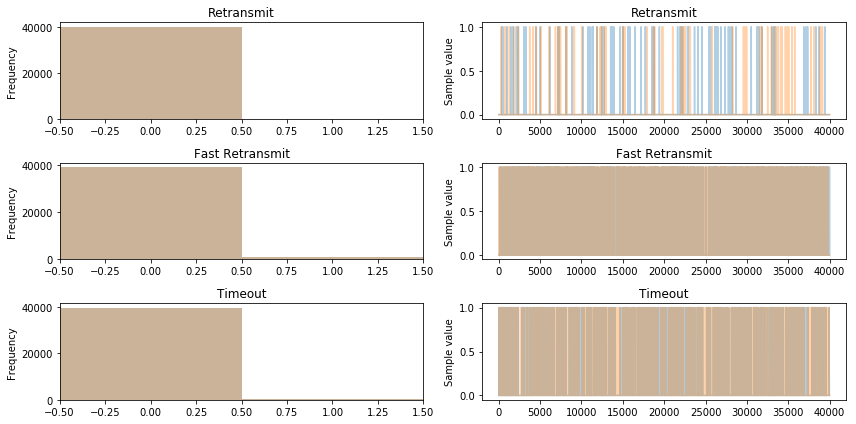

In [33]:
with model:
        trace = pm.sample(40000, chains=2)
        pm.traceplot(trace)

Imported from the "Wet Grass" example to determine the conditional probabilities from the trace.

In [34]:
## From "Wet Grass Example"
def calcCondProb(trace, event, cond):
    # find all samples satisfy conditions
    for k, v in cond.items():
        trace = [smp for smp in trace if smp[k] == v]
    # record quantity of all samples fulfill condition
    nCondSample = len(trace)
    # find all samples satisfy event
    for k, v in event.items():
        trace = [smp for smp in trace if smp[k] == v]
    # calculate conditional probability
    return len(trace) / nCondSample

In [35]:
print('P(R = true | T = true) = ', 
      calcCondProb(trace, {'Retransmit' : 1}, {'Timeout' : 1}))
print('P(R = true | T = false) = ', 
      calcCondProb(trace, {'Retransmit' : 1}, {'Timeout' : 0}))
print('P(R = true | F = true) = ', 
      calcCondProb(trace, {'Retransmit' : 1}, {'Fast Retransmit' : 1}))
print('P(R = true | F = false) = ', 
      calcCondProb(trace, {'Retransmit' : 1}, {'Fast Retransmit' : 0}))

P(R = true | T = true) =  0.06595744680851064
P(R = true | T = false) =  0.0010624841892233746
P(R = true | F = true) =  0.017130620985010708
P(R = true | F = false) =  0.0014590692673936416


We now know `P(R = true | T = true)`.  Due to the small probabilities, the value of this fluctuates betwee 0.04 - 0.07.  When calculating the conditional probability using variable elimination, we get the value ~0.05.  This seems to be accurate to the sampling result.

### Variable Elimination
$$
\begin{align}
P(R = true | T = true) & = \sum_{F} P(R, F|T) \\
& = \sum_{F} \dfrac{P(R,F,T)}{P(T)} \\
& = \dfrac{P(R) \sum_{F} P(T|R,F)P(F)}{\sum_{R} P(R) \sum_{F} P(T|R,F) P(F)} \\
P(R) \sum_{F} P(T|R,F)P(F) & = 0.0019491314899390418 \times (0.176734807584152976 \times (1-0.0004108463434675431) + 0.0236974833272821081 \times 0.0004108463434675431) \approx 0.00034435682 \\
\dfrac{P(R) \sum_{F} P(T|R,F)P(F)}{\sum_{R} P(R) \sum_{F} P(T|R,F) P(F)} & = \dfrac{0.00034435682}{0.00034435682 + 0.00619382033} \\
& \approx 0.05266862798
\end{align}
$$

## Conclusion
From this exercise, it can be concluded that the sampling method provides an accurate alternative for variable elimination, which is computationally expensive and slow to do by hand.  In addition, it can be noted that networks with very small probabilities have a large amount of variance.